### The example is derived from [AI-sarwar-praject](https://www.kaggle.com/code/laraibakhtar/ai-sarwar-praject), a Kaggle notebook.

This notebook is based on a Kaggle example, [AI-sarwar-praject](https://www.kaggle.com/code/laraibakhtar/ai-sarwar-praject). The Kaggle notebook code was distributed under the [Apache 2.0 License](http://www.apache.org/licenses/LICENSE-2.0). As instructed, the text of the license is located in the same directory as this notebook in the file [AI-SARWAR-LICENSE](AI-SARWAR-LICENSE).

### Setup

You first need to run the code in [make_h5py.ipynb](make_h5py.ipynb) to generate the image database this model uses for training.


In [1]:
# import pandas as pd
import numpy as np
import os
import tensorflow as tf
# import cv2
import h5py
# from PIL import Image
import keras
from keras.layers import Dense,Input, InputLayer, Flatten
from keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,f1_score

2024-05-17 00:52:43.978122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


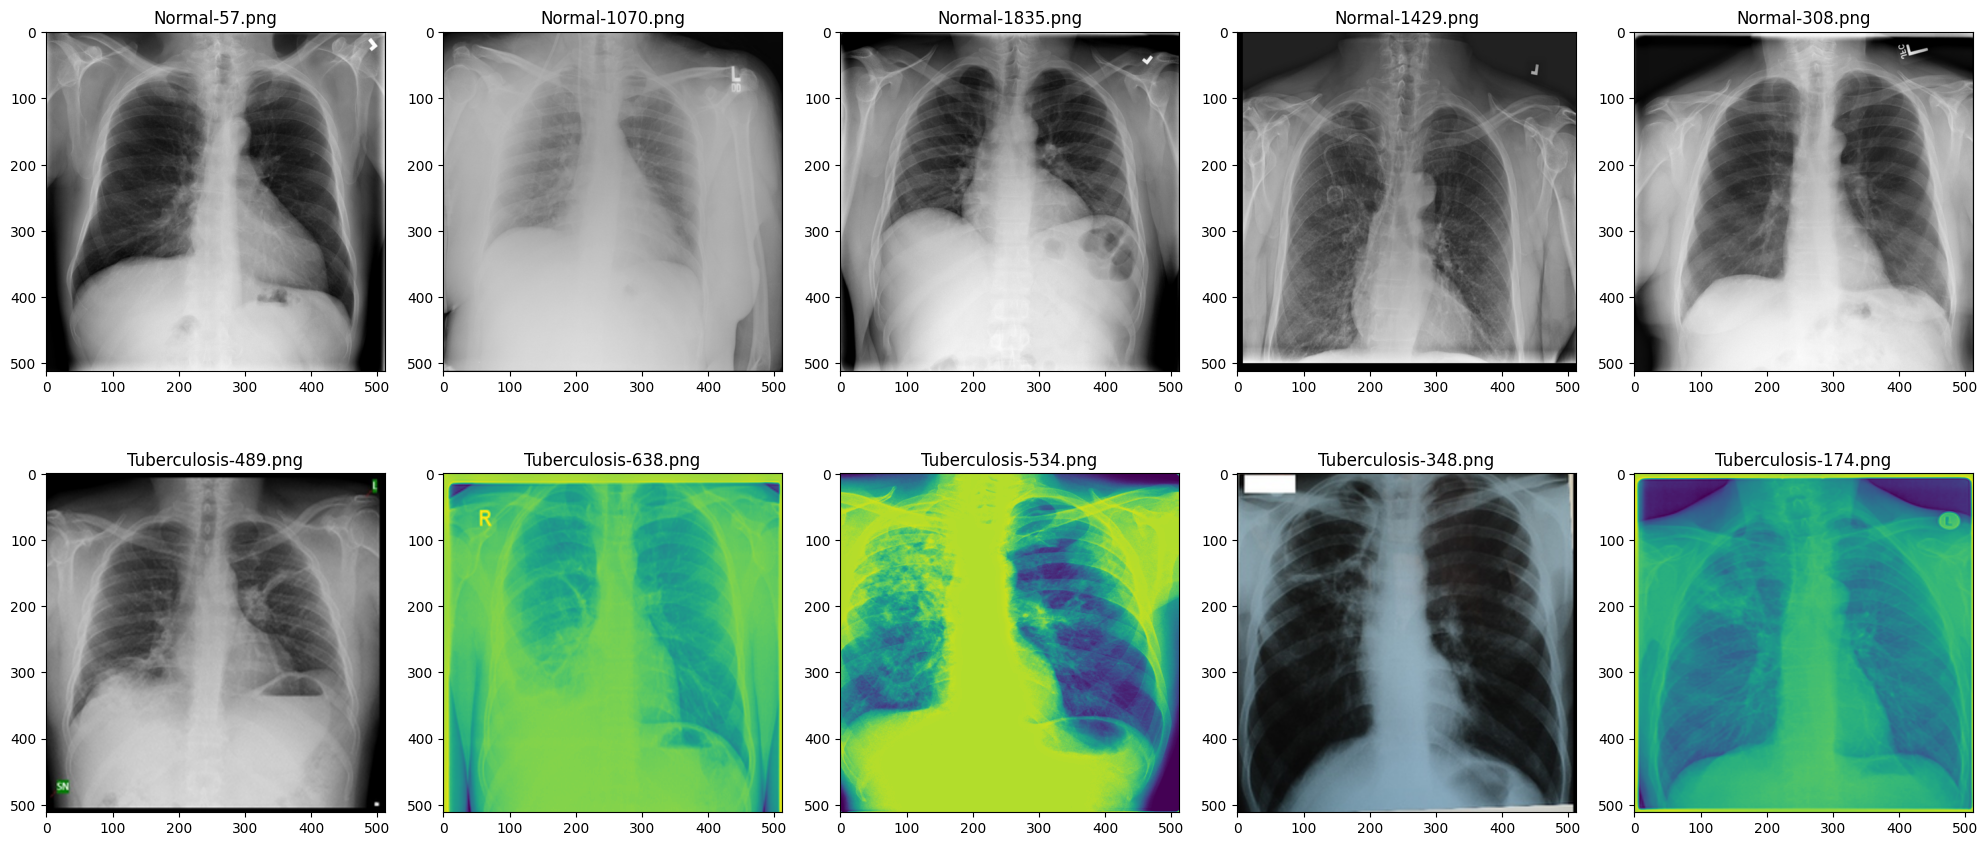

In [2]:
#View some samples of the dataset
import random
plt.figure(figsize=(20,9))
folder=r'../TB_Chest_Radiography_Database/Normal'
for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(2,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)
folder=r'../TB_Chest_Radiography_Database/Tuberculosis'
for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(2,5,i+6)
    ax.title.set_text(file)
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [3]:
# Open the HDF5 file
dataset_dir = "../TB_Chest_Radiography_Database"
with h5py.File(f"{dataset_dir}/tb-xraydb-md.h5py", "r") as h5f:
    # Load the images and labels datasets
    images = h5f['images'][:]
    labels = h5f['labels'][:]

In [4]:
from sklearn.preprocessing import LabelEncoder
# Convert class labels to one-hot encoded vectors
label_encoder = LabelEncoder()
encoded_class_names = label_encoder.fit_transform(labels)

In [5]:
from sklearn.model_selection import train_test_split


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_class_names, test_size=0.33, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check the shapes of the datasets
print("Train images shape:", X_train.shape)
print("Train labels shape:", X_test.shape)
print("Validation images shape:", y_train.shape)
print("Validation labels shape:", y_test.shape)

Train images shape: (2814, 256, 256)
Train labels shape: (1386, 256, 256)
Validation images shape: (2814,)
Validation labels shape: (1386,)


In [6]:
cwidth = 128
model = keras.Sequential([
    # keras.layers.Conv2D(cwidth, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    keras.layers.Conv2D(cwidth, (3, 3)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(cwidth, (3, 3)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    #begin
    keras.layers.Conv2D(cwidth, (3, 3)),
    keras.layers.LeakyReLU(alpha=0.02),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    #end

    keras.layers.GlobalMaxPooling2D(),
    
    keras.layers.Dense(cwidth*4),
    keras.layers.LeakyReLU(alpha=0.02),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10),
    keras.layers.Activation('softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-05-17 00:52:52.406066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 00:52:52.410518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 00:52:52.410558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 00:52:52.412359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to rea

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,626 (1.40 MB)

 Trainable params: 367,626 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


I0000 00:00:1715907174.630323   26600 service.cc:145] XLA service 0x7f92280014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715907174.630378   26600 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-17 00:52:54.658001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 00:52:54.770218: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 1/71 ━━━━━━━━━━━━━━━━━━━━ 13:52 12s/step - accuracy: 0.0000e+00 - loss: 2.4402

I0000 00:00:1715907185.212313   26600 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.7664 - loss: 0.7869 - val_accuracy: 0.8384 - val_loss: 0.4005
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8361 - loss: 0.3388 - val_accuracy: 0.8774 - val_loss: 0.3687
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8436 - loss: 0.2890 - val_accuracy: 0.8544 - val_loss: 0.2994
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8674 - loss: 0.2596 - val_accuracy: 0.9023 - val_loss: 0.2514
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9251 - loss: 0.1718 - val_accuracy: 0.9290 - val_loss: 0.1820
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9340 - loss: 0.1625 - val_accuracy: 0.9503 - val_loss: 0.1431
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9549 - loss: 0.1148 - val_accuracy: 0.9591 - val_loss: 0.1222
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9597 - loss: 0.1022 - val_accuracy: 0.9645 - val_loss: 

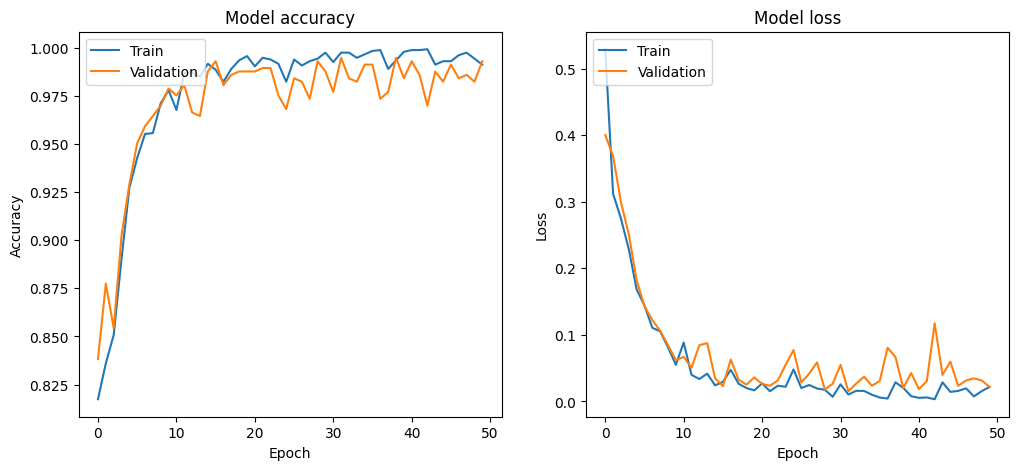

In [9]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1 Score: 0.9744657332350775
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1151
           1       0.95      0.96      0.96       235

    accuracy                           0.99      1386
   macro avg       0.97      0.98      0.97      1386
weighted avg       0.99      0.99      0.99      1386



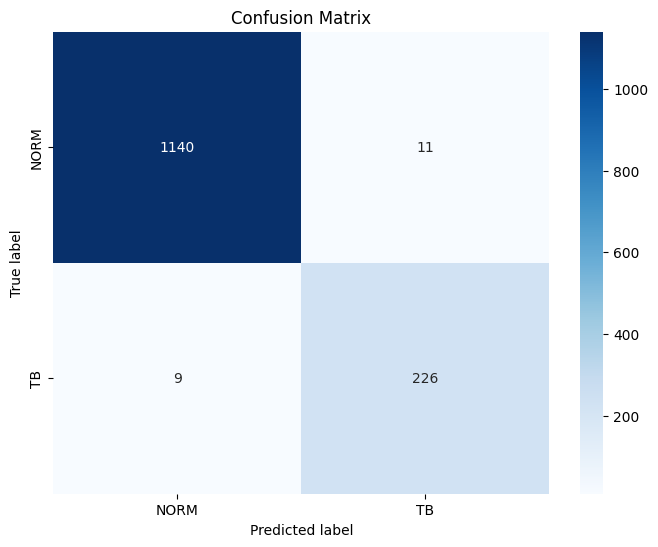

In [10]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
#predicted_class_names = label_encoder.inverse_transform(predicted_labels)

f1 = f1_score(y_test, predicted_labels, average='macro')
report = classification_report(y_test, predicted_labels)

print("F1 Score:", f1)
print("Classification Report:")
print(report)

import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORM', 'TB'], yticklabels=['NORM', 'TB'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()